In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = False

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/5km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_5km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_5km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_5km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_5km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
737500.0,482500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
192500.0,512500.0,4,0,20,40,0,0,0,0,0,0,...,3.727707e+00,4.485687e+00,6.738271e-01,-3.400000e+38,2.312639e+00,-3.400000e+38,1.580212e-01,9.782177e-02,1.170731e+01,1
102500.0,17500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
612500.0,597500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
557500.0,567500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
682500.0,652500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
347500.0,397500.0,10,0,0,89,0,0,0,0,0,0,...,8.071499e+00,4.071703e+00,2.633524e+00,2.812694e+00,1.106602e+01,1.534388e+00,1.781213e+01,6.526572e+00,4.397215e+00,0
152500.0,497500.0,8,0,0,62,0,0,0,0,0,0,...,4.750452e+01,1.822008e+00,5.513314e+00,4.355340e+00,1.405412e+01,3.515530e+00,4.699878e+00,4.760974e-01,2.604246e+00,1
507500.0,307500.0,0,0,0,16,0,0,80,0,1,3,...,2.270524e-01,4.497782e-02,2.757946e-01,-3.400000e+38,1.606501e-01,-3.400000e+38,1.398130e-01,4.127790e-02,-3.400000e+38,0
877500.0,502500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
572500.0,512500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
322500.0,632500.0,1,0,97,2,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
42500.0,537500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
517500.0,687500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
527500.0,682500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
842500.0,647500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1102500.0,517500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
702500.0,142500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
457500.0,72500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1022500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
572500.0,372500.0,0,100,0,0,0,0,0,0,0,0,...,1.724984e+00,1.237703e-01,1.135346e+00,-3.400000e+38,2.018772e+00,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
142500.0,492500.0,41,1,0,26,3,0,0,0,29,0,...,2.665593e+01,5.705609e+00,4.089279e+00,1.691231e+01,1.144378e+01,1.289634e+01,2.569174e+01,5.895841e+00,5.446615e+00,0
1162500.0,77500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
192500.0,492500.0,20,0,0,66,0,0,0,0,0,0,...,5.337983e+01,2.080033e+01,5.672998e+00,1.482462e-01,3.748989e+01,1.413136e-01,7.069144e+00,3.360870e+00,1.302996e+01,0
582500.0,187500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
47500.0,592500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
607500.0,497500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
72500.0,572500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
487500.0,597500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1177500.0,672500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
962500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
827500.0,97500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1197500.0,232500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
522500.0,562500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
747500.0,537500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1072500.0,232500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
152500.0,117500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
42500.0,437500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
712500.0,387500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
297500.0,127500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
552500.0,22500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
937500.0,402500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
797500.0,27500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
352500.0,357500.0,1,0,34,60,1,0,0,0,0,0,...,2.156326e+00,1.587232e-01,1.915912e+00,-3.400000e+38,7.753127e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
7500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1297500.0,302500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
677500.0,257500.0,13,8,0,0,0,0,0,0,0,79,...,4.846918e+00,1.218250e+00,3.318167e+00,-3.400000e+38,3.131152e+00,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
652500.0,132500.0,0,0,7,0,0,0,0,0,0,66,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1227500.0,472500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
97500.0,347500.0,6,0,0,88,0,0,0,0,0,0,...,1.695918e-01,1.681548e-02,6.111417e-02,1.309611e+00,4.648258e-02,7.005512e-01,4.110441e+00,1.560703e+00,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
942500.0,297500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
82500.0,577500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
192500.0,122500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,2.058587e-01,0
767500.0,182500.0,57,37,0,0,0,0,0,0,0,6,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
402500.0,572500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
657500.0,167500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
502500.0,37500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1107500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
427500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
332500.0,232500.0,15,0,0,63,0,0,0,5,0,0,...,3.355660e-01,5.450358e-02,1.901676e-01,-3.400000e+38,3.042587e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
607500.0,262500.0,0,87,0,0,0,0,12,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
637500.0,577500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
947500.0,142500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
277500.0,487500.0,1,0,0,18,0,0,0,0,0,0,...,3.586569e+01,8.723521e+01,4.556832e+00,4.174417e+01,2.017966e+01,3.252745e+01,3.649424e+01,1.203590e+01,1.858756e+01,0
342500.0,132500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
702500.0,382500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
182500.0,97500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
397500.0,57500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
162500.0,47500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1077500.0,67500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
457500.0,482500.0,9,1,78,7,0,3,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
727500.0,262500.0,2,1,0,0,0,0,97,0,0,0,...,1.269077e+00,5.625580e-01,1.424763e+00,1.744249e+00,3.535766e-01,9.948443e-01,2.993498e+00,1.515700e+01,1.056455e+01,0
847500.0,327500.0,11,47,19,21,0,0,1,0,0,0,...,5.120189e+00,3.932381e+00,4.848222e+00,9.582738e+00,3.031148e+00,4.820299e+00,2.072396e+00,2.154628e+01,5.299575e+00,0
597500.0,177500.0,0,0,0,0,0,0,0,0,0,0,...,1.386646e-01,1.683060e-02,4.229048e-02,-3.400000e+38,4.550851e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
92500.0,237500.0,28,0,3,65,0,0,0,0,0,0,...,1.988231e+00,2.734604e-01,3.399648e-01,4.722281e+00,2.067424e+00,3.644626e+00,7.037059e+00,8.540914e-01,1.959437e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
852500.0,177500.0,0,0,0,0,0,0,0,0,0,100,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
122500.0,147500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
942500.0,652500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
997500.0,652500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
17500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
682500.0,472500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1207500.0,517500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
767500.0,307500.0,0,0,0,0,0,0,92,0,8,0,...,6.829206e+00,2.213779e+01,4.902132e+00,-3.400000e+38,5.244846e+00,-3.400000e+38,9.222322e-01,1.169783e+01,8.257946e+00,0
802500.0,217500.0,8,92,0,0,0,0,0,0,0,1,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
127500.0,452500.0,10,0,81,1,0,8,0,0,0,0,...,6.481049e+00,8.807539e+00,1.171137e+00,-3.400000e+38,3.429533e+00,-3.400000e+38,-3.400000e+38,-3.400000e+38,2.452816e+01,1


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
862500.0,292500.0,0,0,0,0,0,0,0,0,0,0,...,1.164959e-02,1.400844e-04,9.666220e-03,-3.400000e+38,5.551423e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
2500.0,597500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1092500.0,67500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
172500.0,647500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
232500.0,382500.0,4,0,58,37,0,0,0,0,0,0,...,1.806545e+01,2.717313e+01,3.184017e+00,1.338633e+01,1.289514e+01,6.870023e+00,2.902540e+01,2.545118e+01,1.163593e+01,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
777500.0,237500.0,0,32,0,0,0,0,68,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1282500.0,392500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
332500.0,87500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
267500.0,332500.0,4,28,4,31,0,0,32,0,0,0,...,4.510304e-02,1.154198e-02,2.962469e-02,-3.400000e+38,2.442408e-02,-3.400000e+38,6.897675e-01,8.873050e-01,2.427112e+00,0
1062500.0,437500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1127500.0,167500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
872500.0,507500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
912500.0,142500.0,0,0,0,0,0,0,0,0,1,44,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
272500.0,687500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1052500.0,602500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


In [4]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 5km data before drop: 
 Occurrence
0    35813
1      587
dtype: int64 

Barnacle Goose 5km data after drop: 
 Occurrence
0    7378
1     587
dtype: int64 

Canada Goose 5km data before drop: 
 Occurrence
0    32095
1     4305
dtype: int64 

Canada Goose 5km data after drop: 
 Occurrence
1    4305
0    3660
dtype: int64 

Egyptian Goose 5km data before drop: 
 Occurrence
0    35915
1      485
dtype: int64 

Egyptian Goose 5km data after drop: 
 Occurrence
0    7480
1     485
dtype: int64 

Gadwall 5km data before drop: 
 Occurrence
0    35001
1     1399
dtype: int64 

Gadwall 5km data after drop: 
 Occurrence
0    6566
1    1399
dtype: int64 

Goshawk 5km data before drop: 
 Occurrence
0    35954
1      446
dtype: int64 

Goshawk 5km data after drop: 
 Occurrence
0    7519
1     446
dtype: int64 

Grey Partridge 5km data before drop: 
 Occurrence
0    34771
1     1629
dtype: int64 

Grey Partridge 5km data after drop: 
 Occurrence
0    6336
1    1629
dtype: int64 

Indian

In [5]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [6]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [7]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [8]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [9]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 5km,5267,0.661268
1,Canada Goose 5km,4305,0.540490
10,Pheasant 5km,3848,0.483114
16,Rock Dove 5km,2830,0.355304
7,Little Owl 5km,2158,0.270935
14,Red-legged Partridge 5km,2150,0.269931
19,Wigeon 5km,1857,0.233145
5,Grey Partridge 5km,1629,0.204520
3,Gadwall 5km,1399,0.175643
11,Pink-footed Goose 5km,1313,0.164846


In [10]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 5km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9358316221765913,
        "recall": 0.9886117136659436,
        "f1-score": 0.9614978902953586,
        "support": 1844
    },
    "1": {
        "precision": 0.5227272727272727,
        "recall": 0.1554054054054054,
        "f1-score": 0.23958333333333334,
        "support": 148
    },
    "accuracy": 0.9267068273092369,
    "macro avg": {
        "precision": 0.729279447451932,
        "recall": 0.5720085595356745,
        "f1-score": 0.6005406118143459,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9051391303500355,
        "recall": 0.9267068273092369,
        "f1-score": 0.9078616681917543,
        "support": 1992
    }
} 

Barnacle Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9397066811515481,
        "recall": 0.938177874186551,
        "f1-score": 0.9389416553595659,
        "support": 1844
    },
    "1": {
        "precision": 0.2450331

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9355971896955504,
        "recall": 0.871319520174482,
        "f1-score": 0.9023150762281198,
        "support": 917
    },
    "1": {
        "precision": 0.8963093145869947,
        "recall": 0.9488372093023256,
        "f1-score": 0.921825576140985,
        "support": 1075
    },
    "accuracy": 0.9131526104417671,
    "macro avg": {
        "precision": 0.9159532521412725,
        "recall": 0.9100783647384039,
        "f1-score": 0.9120703261845524,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9143951486605617,
        "recall": 0.9131526104417671,
        "f1-score": 0.9128440859702533,
        "support": 1992
    }
} 

Canada Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9213483146067416,
        "recall": 0.8942202835332607,
        "f1-score": 0.9075816270060874,
        "support": 917
    },
    "1": {
        "precision": 0.9119782214156

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9595588235294118,
        "recall": 0.981203007518797,
        "f1-score": 0.9702602230483273,
        "support": 1862
    },
    "1": {
        "precision": 0.6022727272727273,
        "recall": 0.4076923076923077,
        "f1-score": 0.4862385321100917,
        "support": 130
    },
    "accuracy": 0.9437751004016064,
    "macro avg": {
        "precision": 0.7809157754010696,
        "recall": 0.6944476576055523,
        "f1-score": 0.7282493775792095,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9362419598178812,
        "recall": 0.9437751004016064,
        "f1-score": 0.9386724620935227,
        "support": 1992
    }
} 

Egyptian Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9638874137015401,
        "recall": 0.9747583243823845,
        "f1-score": 0.9692923898531375,
        "support": 1862
    },
    "1": {
        "precision": 0.5688073

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 5km Classification Report: 
 {
    "0": {
        "precision": 0.9131195335276968,
        "recall": 0.9566279780085523,
        "f1-score": 0.9343675417661097,
        "support": 1637
    },
    "1": {
        "precision": 0.7436823104693141,
        "recall": 0.5802816901408451,
        "f1-score": 0.6518987341772152,
        "support": 355
    },
    "accuracy": 0.8895582329317269,
    "macro avg": {
        "precision": 0.8284009219985055,
        "recall": 0.7684548340746986,
        "f1-score": 0.7931331379716624,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8829236428722119,
        "recall": 0.8895582329317269,
        "f1-score": 0.8840279701325467,
        "support": 1992
    }
} 

Gadwall 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9126040428061831,
        "recall": 0.9376908979841173,
        "f1-score": 0.9249774028321783,
        "support": 1637
    },
    "1": {
        "precision": 0.6709677419354839,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 5km Classification Report: 
 {
    "0": {
        "precision": 0.954337899543379,
        "recall": 0.9926121372031662,
        "f1-score": 0.9730988101396792,
        "support": 1895
    },
    "1": {
        "precision": 0.3333333333333333,
        "recall": 0.07216494845360824,
        "f1-score": 0.11864406779661016,
        "support": 97
    },
    "accuracy": 0.9477911646586346,
    "macro avg": {
        "precision": 0.6438356164383562,
        "recall": 0.5323885428283872,
        "f1-score": 0.5458714389681447,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9240982193614641,
        "recall": 0.9477911646586346,
        "f1-score": 0.9314913251962669,
        "support": 1992
    }
} 

Goshawk 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9625195210827694,
        "recall": 0.9757255936675462,
        "f1-score": 0.9690775681341719,
        "support": 1895
    },
    "1": {
        "precision": 0.352112676056338,
   

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 5km Classification Report: 
 {
    "0": {
        "precision": 0.9587491683300067,
        "recall": 0.902316844082655,
        "f1-score": 0.9296774193548387,
        "support": 1597
    },
    "1": {
        "precision": 0.6809815950920245,
        "recall": 0.8430379746835444,
        "f1-score": 0.7533936651583709,
        "support": 395
    },
    "accuracy": 0.8905622489959839,
    "macro avg": {
        "precision": 0.8198653817110155,
        "recall": 0.8726774093830997,
        "f1-score": 0.8415355422566049,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9036697549620333,
        "recall": 0.8905622489959839,
        "f1-score": 0.8947215544413825,
        "support": 1992
    }
} 

Grey Partridge 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9104385423100679,
        "recall": 0.9229805886036319,
        "f1-score": 0.9166666666666666,
        "support": 1597
    },
    "1": {
        "precision": 0.6702412

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 5km Classification Report: 
 {
    "0": {
        "precision": 0.9617706237424547,
        "recall": 0.9979123173277662,
        "f1-score": 0.9795081967213115,
        "support": 1916
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 76
    },
    "accuracy": 0.9598393574297188,
    "macro avg": {
        "precision": 0.48088531187122735,
        "recall": 0.4989561586638831,
        "f1-score": 0.48975409836065575,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9250765638004735,
        "recall": 0.9598393574297188,
        "f1-score": 0.9421374020672856,
        "support": 1992
    }
} 

Indian Peafowl 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9646878198567042,
        "recall": 0.9838204592901879,
        "f1-score": 0.9741602067183461,
        "support": 1916
    },
    "1": {
        "precision": 0.18421052631578946,
        "recall": 0.09210526315

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 5km Classification Report: 
 {
    "0": {
        "precision": 0.9746376811594203,
        "recall": 0.9069453809844908,
        "f1-score": 0.9395738735592035,
        "support": 1483
    },
    "1": {
        "precision": 0.7745098039215687,
        "recall": 0.931237721021611,
        "f1-score": 0.8456735057983942,
        "support": 509
    },
    "accuracy": 0.9131526104417671,
    "macro avg": {
        "precision": 0.8745737425404945,
        "recall": 0.9190915510030508,
        "f1-score": 0.8926236896787989,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9235005880298688,
        "recall": 0.9131526104417671,
        "f1-score": 0.9155802554918079,
        "support": 1992
    }
} 

Little Owl 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9678800856531049,
        "recall": 0.9143627781523938,
        "f1-score": 0.9403606102635229,
        "support": 1483
    },
    "1": {
        "precision": 0.785109983079526

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 5km Classification Report: 
 {
    "0": {
        "precision": 0.9385775862068966,
        "recall": 0.963495575221239,
        "f1-score": 0.9508733624454149,
        "support": 1808
    },
    "1": {
        "precision": 0.5147058823529411,
        "recall": 0.3804347826086957,
        "f1-score": 0.4375,
        "support": 184
    },
    "accuracy": 0.9096385542168675,
    "macro avg": {
        "precision": 0.7266417342799188,
        "recall": 0.6719651789149673,
        "f1-score": 0.6941866812227074,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8994247782203867,
        "recall": 0.9096385542168675,
        "f1-score": 0.9034533329825853,
        "support": 1992
    }
} 

Mandarin Duck 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9399449035812673,
        "recall": 0.9435840707964602,
        "f1-score": 0.9417609715705216,
        "support": 1808
    },
    "1": {
        "precision": 0.423728813559322,
    

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 5km Classification Report: 
 {
    "0": {
        "precision": 0.92776886035313,
        "recall": 0.8328530259365994,
        "f1-score": 0.8777524677296886,
        "support": 694
    },
    "1": {
        "precision": 0.9152666179693206,
        "recall": 0.9653312788906009,
        "f1-score": 0.9396325459317585,
        "support": 1298
    },
    "accuracy": 0.9191767068273092,
    "macro avg": {
        "precision": 0.9215177391612253,
        "recall": 0.8990921524136002,
        "f1-score": 0.9086925068307236,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9196223188801458,
        "recall": 0.9191767068273092,
        "f1-score": 0.9180739243091497,
        "support": 1992
    }
} 

Mute Swan 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8452054794520548,
        "recall": 0.8890489913544669,
        "f1-score": 0.8665730337078652,
        "support": 694
    },
    "1": {
        "precision": 0.938985736925515,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 5km Classification Report: 
 {
    "0": {
        "precision": 0.9282744282744283,
        "recall": 0.8636363636363636,
        "f1-score": 0.8947895791583166,
        "support": 1034
    },
    "1": {
        "precision": 0.8631067961165049,
        "recall": 0.9279749478079332,
        "f1-score": 0.8943661971830986,
        "support": 958
    },
    "accuracy": 0.8945783132530121,
    "macro avg": {
        "precision": 0.8956906121954666,
        "recall": 0.8958056557221484,
        "f1-score": 0.8945778881707076,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8969337698370333,
        "recall": 0.8945783132530121,
        "f1-score": 0.8945859647344919,
        "support": 1992
    }
} 

Pheasant 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9408658922914467,
        "recall": 0.8617021276595744,
        "f1-score": 0.8995456839979807,
        "support": 1034
    },
    "1": {
        "precision": 0.8631578947368421,


c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9011173184357542,
        "recall": 0.9641362821279139,
        "f1-score": 0.9315622292809702,
        "support": 1673
    },
    "1": {
        "precision": 0.7029702970297029,
        "recall": 0.445141065830721,
        "f1-score": 0.5451055662188099,
        "support": 319
    },
    "accuracy": 0.8810240963855421,
    "macro avg": {
        "precision": 0.8020438077327285,
        "recall": 0.7046386739793175,
        "f1-score": 0.7383338977498901,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8693859430198253,
        "recall": 0.8810240963855421,
        "f1-score": 0.869674841973325,
        "support": 1992
    }
} 

Pink-footed Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9275184275184275,
        "recall": 0.9025702331141662,
        "f1-score": 0.9148742805210542,
        "support": 1673
    },
    "1": {
        "precision": 0.55

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 5km Classification Report: 
 {
    "0": {
        "precision": 0.9353671147880042,
        "recall": 0.9820846905537459,
        "f1-score": 0.9581567796610171,
        "support": 1842
    },
    "1": {
        "precision": 0.43103448275862066,
        "recall": 0.16666666666666666,
        "f1-score": 0.2403846153846154,
        "support": 150
    },
    "accuracy": 0.9206827309236948,
    "macro avg": {
        "precision": 0.6832007987733124,
        "recall": 0.5743756786102063,
        "f1-score": 0.5992706975228163,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8973902599665144,
        "recall": 0.9206827309236948,
        "f1-score": 0.904107670905264,
        "support": 1992
    }
} 

Pintail 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9503311258278145,
        "recall": 0.9348534201954397,
        "f1-score": 0.9425287356321839,
        "support": 1842
    },
    "1": {
        "precision": 0.3333333333333333,
 

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 5km Classification Report: 
 {
    "0": {
        "precision": 0.9102564102564102,
        "recall": 0.9709401709401709,
        "f1-score": 0.9396195202646815,
        "support": 1755
    },
    "1": {
        "precision": 0.575,
        "recall": 0.2911392405063291,
        "f1-score": 0.38655462184873945,
        "support": 237
    },
    "accuracy": 0.8900602409638554,
    "macro avg": {
        "precision": 0.7426282051282052,
        "recall": 0.63103970572325,
        "f1-score": 0.6630870710567105,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8703689759036145,
        "recall": 0.8900602409638554,
        "f1-score": 0.8738181242182065,
        "support": 1992
    }
} 

Pochard 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9073464912280702,
        "recall": 0.9430199430199431,
        "f1-score": 0.9248393405979324,
        "support": 1755
    },
    "1": {
        "precision": 0.40476190476190477,
        "recall

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 5km Classification Report: 
 {
    "0": {
        "precision": 0.9474789915966386,
        "recall": 0.9135719108710331,
        "f1-score": 0.9302165692677895,
        "support": 1481
    },
    "1": {
        "precision": 0.7730496453900709,
        "recall": 0.8532289628180039,
        "f1-score": 0.8111627906976744,
        "support": 511
    },
    "accuracy": 0.8980923694779116,
    "macro avg": {
        "precision": 0.8602643184933547,
        "recall": 0.8834004368445185,
        "f1-score": 0.870689679982732,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9027333109181466,
        "recall": 0.8980923694779116,
        "f1-score": 0.899676167234994,
        "support": 1992
    }
} 

Red-legged Partridge 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9483734087694484,
        "recall": 0.9054692775151925,
        "f1-score": 0.9264248704663213,
        "support": 1481
    },
    "1": {
        "precision"

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 5km Classification Report: 
 {
    "0": {
        "precision": 0.9810159055926116,
        "recall": 0.9881136950904392,
        "f1-score": 0.984552008238929,
        "support": 1935
    },
    "1": {
        "precision": 0.46511627906976744,
        "recall": 0.3508771929824561,
        "f1-score": 0.4,
        "support": 57
    },
    "accuracy": 0.9698795180722891,
    "macro avg": {
        "precision": 0.7230660923311896,
        "recall": 0.6694954440364477,
        "f1-score": 0.6922760041194644,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9662537174842774,
        "recall": 0.9698795180722891,
        "f1-score": 0.9678253694489596,
        "support": 1992
    }
} 

Ring-necked Parakeet 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9809964047252183,
        "recall": 0.9870801033591732,
        "f1-score": 0.9840288511076766,
        "support": 1935
    },
    "1": {
        "precision": 0.4444444444

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 5km Classification Report: 
 {
    "0": {
        "precision": 0.9165302782324058,
        "recall": 0.8543096872616324,
        "f1-score": 0.8843268851164627,
        "support": 1311
    },
    "1": {
        "precision": 0.7519480519480519,
        "recall": 0.8502202643171806,
        "f1-score": 0.7980702963473466,
        "support": 681
    },
    "accuracy": 0.8529116465863453,
    "macro avg": {
        "precision": 0.8342391650902289,
        "recall": 0.8522649757894065,
        "f1-score": 0.8411985907319046,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8602649689454356,
        "recall": 0.8529116465863453,
        "f1-score": 0.8548385633535269,
        "support": 1992
    }
} 

Rock Dove 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9233937397034596,
        "recall": 0.855072463768116,
        "f1-score": 0.887920792079208,
        "support": 1311
    },
    "1": {
        "precision": 0.7557840616966581,


c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ruddy Duck 5km Classification Report: 
 {
    "0": {
        "precision": 0.9834254143646409,
        "recall": 0.9994895354772844,
        "f1-score": 0.9913924050632913,
        "support": 1959
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 33
    },
    "accuracy": 0.9829317269076305,
    "macro avg": {
        "precision": 0.49171270718232046,
        "recall": 0.4997447677386422,
        "f1-score": 0.49569620253164565,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.967133728283299,
        "recall": 0.9829317269076305,
        "f1-score": 0.9749687357023031,
        "support": 1992
    }
} 

Ruddy Duck 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9848637739656912,
        "recall": 0.9964267483409903,
        "f1-score": 0.9906115199188025,
        "support": 1959
    },
    "1": {
        "precision": 0.3,
        "recall": 0.09090909090909091,
        "f1-score

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 5km Classification Report: 
 {
    "0": {
        "precision": 0.9047864127637674,
        "recall": 0.9854260089686099,
        "f1-score": 0.9433861014220553,
        "support": 1784
    },
    "1": {
        "precision": 0.46938775510204084,
        "recall": 0.11057692307692307,
        "f1-score": 0.17898832684824903,
        "support": 208
    },
    "accuracy": 0.8940763052208835,
    "macro avg": {
        "precision": 0.6870870839329041,
        "recall": 0.5480014660227664,
        "f1-score": 0.5611872141351522,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8593230991123421,
        "recall": 0.8940763052208835,
        "f1-score": 0.8635694663259952,
        "support": 1992
    }
} 

Whooper Swan 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9271597967250141,
        "recall": 0.9204035874439462,
        "f1-score": 0.9237693389592125,
        "support": 1784
    },
    "1": {
        "precision": 0.3574660

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 5km Classification Report: 
 {
    "0": {
        "precision": 0.8940092165898618,
        "recall": 0.8846905537459283,
        "f1-score": 0.8893254747871644,
        "support": 1535
    },
    "1": {
        "precision": 0.6257928118393234,
        "recall": 0.6477024070021882,
        "f1-score": 0.6365591397849463,
        "support": 457
    },
    "accuracy": 0.8303212851405622,
    "macro avg": {
        "precision": 0.7599010142145926,
        "recall": 0.7661964803740582,
        "f1-score": 0.7629423072860553,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8324756337730967,
        "recall": 0.8303212851405622,
        "f1-score": 0.8313364109839447,
        "support": 1992
    }
} 

Wigeon 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8759791122715405,
        "recall": 0.8742671009771987,
        "f1-score": 0.8751222693185523,
        "support": 1535
    },
    "1": {
        "precision": 0.5804347826086956,
    

In [11]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 5km 
 {
    "0": {
        "precision": 0.9358316221765913,
        "recall": 0.9886117136659436,
        "f1-score": 0.9614978902953586,
        "support": 1844
    },
    "1": {
        "precision": 0.5227272727272727,
        "recall": 0.1554054054054054,
        "f1-score": 0.23958333333333334,
        "support": 148
    },
    "accuracy": 0.9267068273092369,
    "macro avg": {
        "precision": 0.729279447451932,
        "recall": 0.5720085595356745,
        "f1-score": 0.6005406118143459,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9051391303500355,
        "recall": 0.9267068273092369,
        "f1-score": 0.9078616681917543,
        "support": 1992
    }
}
Canada Goose 5km 
 {
    "0": {
        "precision": 0.9355971896955504,
        "recall": 0.871319520174482,
        "f1-score": 0.9023150762281198,
        "support": 917
    },
    "1": {
        "precision": 0.8963093145869947,
        "recall": 0.9488372093023256,
        

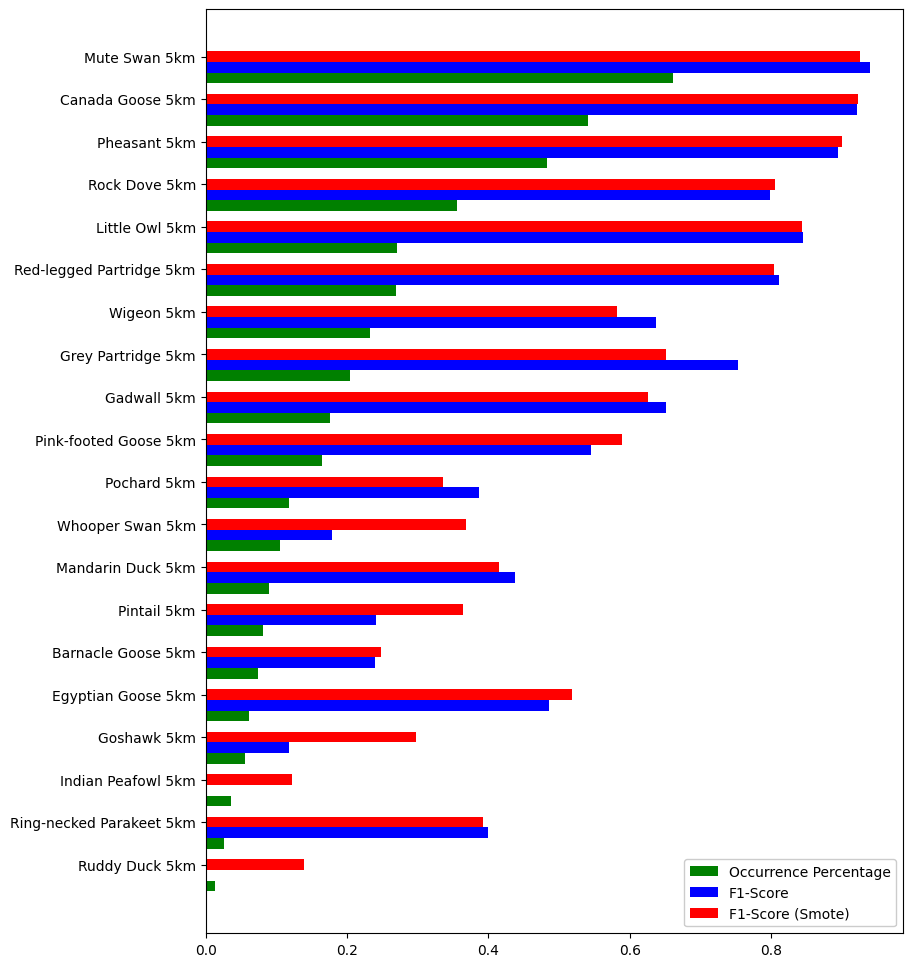

,Labels,F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 5km,0.939633,0.925781,5267,0.661268
1,Canada Goose 5km,0.921826,0.923289,4305,0.540490
10,Pheasant 5km,0.894366,0.900649,3848,0.483114
16,Rock Dove 5km,0.798070,0.806032,2830,0.355304
7,Little Owl 5km,0.845674,0.843636,2158,0.270935
14,Red-legged Partridge 5km,0.811163,0.804408,2150,0.269931
19,Wigeon 5km,0.636559,0.582334,1857,0.233145
5,Grey Partridge 5km,0.753394,0.651042,1629,0.204520
3,Gadwall 5km,0.651899,0.625564,1399,0.175643
11,Pink-footed Goose 5km,0.545106,0.588580,1313,0.164846


In [12]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 'F1': f1, 'F1 (Smote)': f1_smote,'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [13]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/5km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '.csv')
    

Occurrence  Predictions
y         x                                
842500.0  367500.0           0            0
22500.0   197500.0           0            1
          27500.0            0            0
247500.0  252500.0           0            0
737500.0  62500.0            0            0
...                        ...          ...
862500.0  567500.0           0            0
152500.0  232500.0           0            0
1252500.0 592500.0           0            0
1002500.0 322500.0           0            0
192500.0  167500.0           0            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
572500.0,282500.0,1,1
32500.0,162500.0,1,1
37500.0,667500.0,0,0
182500.0,367500.0,1,1
477500.0,332500.0,1,1
...,...,...,...
592500.0,122500.0,0,0
132500.0,482500.0,1,1
1207500.0,432500.0,0,0


Occurrence  Predictions
y         x                                
827500.0  27500.0            0            0
22500.0   392500.0           0            0
          262500.0           0            0
212500.0  317500.0           0            0
727500.0  312500.0           0            0
...                        ...          ...
847500.0  82500.0            0            0
142500.0  512500.0           1            1
1252500.0 512500.0           0            0
1002500.0 337500.0           0            0
167500.0  17500.0            0            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
787500.0,87500.0,0,0
22500.0,2500.0,0,0
27500.0,562500.0,0,0
217500.0,457500.0,1,1
682500.0,387500.0,0,0
...,...,...,...
812500.0,382500.0,0,0
142500.0,342500.0,1,1
1242500.0,372500.0,0,0


Occurrence  Predictions
y         x                                
822500.0  422500.0           0            0
22500.0   647500.0           0            0
          547500.0           0            0
232500.0  392500.0           0            0
727500.0  507500.0           0            0
...                        ...          ...
837500.0  62500.0            0            0
142500.0  447500.0           0            0
1247500.0 517500.0           0            0
987500.0  287500.0           0            0
182500.0  672500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
767500.0  547500.0           0            0
27500.0   627500.0           0            0
          507500.0           0            0
222500.0  412500.0           0            0
662500.0  517500.0           0            0
...                        ...          ...
787500.0  567500.0           0            0
147500.0  522500.0           1            0
1242500.0 92500.0            0            0
957500.0  387500.0           0            0
177500.0  557500.0           1            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
827500.0,87500.0,0,0
22500.0,47500.0,0,0
27500.0,567500.0,0,0
227500.0,152500.0,0,0
732500.0,562500.0,0,0
...,...,...,...
852500.0,692500.0,0,0
142500.0,577500.0,0,1
1252500.0,597500.0,0,0


Occurrence  Predictions
y         x                                
722500.0  412500.0           0            0
27500.0   267500.0           0            0
          62500.0            0            0
197500.0  97500.0            0            0
602500.0  512500.0           0            0
...                        ...          ...
747500.0  412500.0           0            0
137500.0  152500.0           0            0
1242500.0 692500.0           0            0
932500.0  162500.0           0            0
162500.0  537500.0           1            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
822500.0  92500.0            0            0
22500.0   217500.0           0            0
          137500.0           0            0
212500.0  292500.0           0            1
717500.0  197500.0           0            0
...                        ...          ...
842500.0  372500.0           0            0
137500.0  392500.0           1            0
1247500.0 87500.0            0            0
997500.0  362500.0           0            0
172500.0  532500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
582500.0  287500.0           1            1
42500.0   192500.0           0            1
          72500.0            0            0
192500.0  557500.0           1            1
487500.0  317500.0           1            1
...                        ...          ...
607500.0  422500.0           1            1
137500.0  302500.0           1            1
1192500.0 637500.0           0            0
737500.0  417500.0           0            0
162500.0  482500.0           1            1

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
642500.0,327500.0,1,1
32500.0,142500.0,0,1
37500.0,577500.0,0,0
192500.0,352500.0,1,1
537500.0,87500.0,1,0
...,...,...,...
662500.0,347500.0,0,1
137500.0,512500.0,1,1
1217500.0,402500.0,0,0


,,Occurrence,Predictions
y,x,,
817500.0,352500.0,1,1
22500.0,37500.0,0,0
27500.0,642500.0,0,0
272500.0,297500.0,0,0
722500.0,327500.0,1,1
...,...,...,...
837500.0,372500.0,1,1
162500.0,67500.0,0,0
1242500.0,212500.0,0,0


Occurrence  Predictions
y         x                                
837500.0  152500.0           0            1
22500.0   367500.0           0            0
          222500.0           0            0
237500.0  217500.0           0            1
722500.0  332500.0           1            0
...                        ...          ...
857500.0  267500.0           1            0
147500.0  287500.0           1            1
1252500.0 152500.0           0            0
1012500.0 92500.0            0            0
187500.0  572500.0           0            1

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
807500.0,247500.0,0,0
17500.0,27500.0,0,0
22500.0,507500.0,0,0
222500.0,32500.0,0,0
707500.0,677500.0,0,0
...,...,...,...
827500.0,362500.0,0,0
142500.0,302500.0,0,1
1242500.0,242500.0,0,0


Occurrence  Predictions
y         x                                
747500.0  162500.0           0            0
32500.0   612500.0           0            0
          482500.0           0            0
207500.0  202500.0           0            0
627500.0  272500.0           0            0
...                        ...          ...
772500.0  292500.0           0            0
142500.0  532500.0           1            1
1242500.0 452500.0           0            0
937500.0  542500.0           0            0
167500.0  307500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
857500.0  647500.0           0            0
22500.0   632500.0           0            0
          562500.0           0            0
227500.0  442500.0           0            0
752500.0  517500.0           0            0
...                        ...          ...
872500.0  267500.0           0            0
147500.0  322500.0           0            0
1252500.0 547500.0           0            0
1017500.0 362500.0           0            0
177500.0  37500.0            0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
712500.0  332500.0           1            0
27500.0   437500.0           0            0
          137500.0           0            1
197500.0  447500.0           1            1
607500.0  247500.0           0            0
...                        ...          ...
732500.0  332500.0           0            1
142500.0  692500.0           0            0
1232500.0 552500.0           0            0
902500.0  302500.0           0            0
167500.0  562500.0           1            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
857500.0  512500.0           0            0
22500.0   587500.0           0            0
          447500.0           0            0
237500.0  512500.0           0            0
752500.0  77500.0            0            0
...                        ...          ...
872500.0  512500.0           0            0
142500.0  167500.0           0            0
1252500.0 422500.0           0            0
1007500.0 72500.0            0            0
182500.0  142500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
847500.0  507500.0           0            0
27500.0   597500.0           0            0
          472500.0           0            0
267500.0  387500.0           0            0
742500.0  197500.0           0            0
...                        ...          ...
862500.0  607500.0           0            0
162500.0  447500.0           0            0
1247500.0 87500.0            0            0
1002500.0 462500.0           0            0
202500.0  237500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
787500.0  97500.0            0            0
27500.0   167500.0           0            0
          107500.0           0            0
232500.0  602500.0           1            0
687500.0  72500.0            0            0
...                        ...          ...
807500.0  192500.0           1            1
147500.0  602500.0           0            1
1237500.0 332500.0           0            0
957500.0  122500.0           0            0
182500.0  582500.0           1            0

[1992 rows x 2 columns]